In [1]:
from sklearn.ensemble import RandomForestRegressor as rf

In [2]:
# import library
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random

plt.style.use(style='ggplot')
np.random.seed(1234)
random.seed(1234)

In [3]:
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")
submission = pd.read_csv("./data/sample_submission.csv")

In [4]:
all_df = pd.concat([train_df, test_df], axis=0, sort=False).reset_index(drop=True)

In [5]:
from sklearn.preprocessing import LabelEncoder

categories = all_df.columns[all_df.dtypes == "object"]
print(categories)
print(len(categories))

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')
43


In [6]:
for cat in categories:
    le = LabelEncoder()
    all_df[cat].fillna("missing", inplace=True)
    le = le.fit(all_df[cat])
    all_df[cat] = le.transform(all_df[cat])
    all_df[cat] = all_df[cat].astype("category")

In [7]:
all_df["TotalSF"] = all_df["TotalBsmtSF"] + all_df["1stFlrSF"] + all_df["2ndFlrSF"]
all_df["Total_bathrooms"] = (
    all_df["FullBath"]
    + all_df["HalfBath"]
    + all_df["BsmtFullBath"]
    + all_df["BsmtHalfBath"]
)

In [8]:
hasnan_cat = []
for col in all_df.columns:
    tmp_null_count = all_df[col].isnull().sum()
    if (tmp_null_count > 0) & (col != "SalePrice"):
        hasnan_cat.append(col)
        print(col, tmp_null_count)

LotFrontage 486
MasVnrArea 23
BsmtFinSF1 1
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
BsmtFullBath 2
BsmtHalfBath 2
GarageYrBlt 159
GarageCars 1
GarageArea 1
TotalSF 1
Total_bathrooms 2


In [9]:
all_df[hasnan_cat].describe()

,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,GarageYrBlt,GarageCars,GarageArea,TotalSF,Total_bathrooms
count,2433.000000,2896.000000,2918.000000,2918.000000,2918.000000,2918.000000,2917.000000,2917.000000,2760.000000,2918.000000,2918.000000,2918.000000,2917.000000
mean,69.305795,102.201312,441.423235,49.582248,560.772104,1051.777587,0.429894,0.061364,1978.113406,1.766621,472.874572,2548.048663,2.439150
std,23.344905,179.334253,455.610826,169.205611,439.543659,440.766258,0.524736,0.245687,25.574285,0.761624,215.394815,804.677866,0.941799
min,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1895.000000,0.000000,0.000000,334.000000,1.000000
25%,59.000000,0.000000,0.000000,0.000000,220.000000,793.000000,0.000000,0.000000,1960.000000,1.000000,320.000000,2000.500000,2.000000
50%,68.000000,0.000000,368.500000,0.000000,467.000000,989.500000,0.000000,0.000000,1979.000000,2.000000,480.000000,2450.000000,2.000000
75%,80.000000,164.000000,733.000000,0.000000,805.500000,1302.000000,1.000000,0.000000,2002.000000,2.000000,576.000000,2991.750000,3.000000
max,313.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,3.000000,2.000000,2207.000000,5.000000,1488.000000,11752.000000,8.000000


In [10]:
for col in all_df.columns:
    tmp_null_count = all_df[col].isnull().sum()
    if (tmp_null_count > 0) & (col != "SalePrice"):
        print(col, tmp_null_count)
        all_df[col].fillna(all_df[col].median(), inplace=True)

LotFrontage 486
MasVnrArea 23
BsmtFinSF1 1
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
BsmtFullBath 2
BsmtHalfBath 2
GarageYrBlt 159
GarageCars 1
GarageArea 1
TotalSF 1
Total_bathrooms 2


In [11]:
train_df_le = all_df[~all_df["SalePrice"].isnull()]
test_df_le = all_df[all_df["SalePrice"].isnull()]

train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])
train_X = train_df_le.drop(["SalePrice", "SalePrice_log", "Id"], axis=1)
train_Y = train_df_le["SalePrice_log"]

c:\ProgramData\Anaconda3\envs\kaggle_book\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [12]:
from sklearn.model_selection import KFold

folds = 3
kf = KFold(n_splits=folds)

In [13]:
# import mean_squared_error
from pyexpat import model
from sklearn.metrics import mean_squared_error

models_rf = []
rmses_rf = []
oof_rf = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_vaild = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    model_rf = rf(n_estimators=50, random_state=1234)
    model_rf.fit(X_train, y_train)
    y_pred = model_rf.predict(X_vaild)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)
    models_rf.append(model_rf)
    rmses_rf.append(tmp_rmse)
    oof_rf[val_index] = y_pred

0.14041732688138514
0.15352088210494158
0.14194449912040752


In [14]:
sum(rmses_rf) / len(rmses_rf)

0.1452942360355781

In [15]:
test_X = test_df_le.drop(["SalePrice", "Id"], axis=1)

In [16]:
preds_rf = []
for model in models_rf:
    pred = model.predict(test_X)
    preds_rf.append(pred)

In [17]:
preds_array_rf = np.array(preds_rf)
preds_mean_rf = np.mean(preds_array_rf, axis=0)
preds_exp_rf = np.exp(preds_mean_rf)
submission["SalePrice"] = preds_exp_rf

In [18]:
submission.to_csv("./submit/submission_rf.csv", index=False)

In [19]:
import xgboost as xgb

In [20]:
categories = train_X.columns[train_X.dtypes == "category"]
for col in categories:
    train_X[col] = train_X[col].astype("int8")
    test_X[col] = test_X[col].astype("int8")

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_vaild, y_train, y_valid = train_test_split(
    train_X, train_Y, test_size=0.2, random_state=1234, shuffle=True, stratify=None
)

In [22]:
import optuna


def objective(trial):
    xgb_params = {
        "learning_rate": 0.05,
        "seed": 1234,
        "max_depth": trial.suggest_int("max_depth", 3, 16),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.2, 0.9),
        "sublsample": trial.suggest_uniform("sublsample", 0.2, 0.9),
    }

    xgb_train = xgb.DMatrix(X_train, label=y_train)
    xgb_eval = xgb.DMatrix(X_vaild, label=y_valid)
    evals = [(xgb_train, "train"), (xgb_eval, "eval")]
    model_xgb = xgb.train(
        xgb_params,
        xgb_train,
        evals=evals,
        num_boost_round=1000,
        early_stopping_rounds=20,
        verbose_eval=10,
    )

    y_pred = model_xgb.predict(xgb_eval)
    score = np.sqrt(mean_squared_error(y_valid, y_pred))
    return score

In [23]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=50)
study.best_params

[10:16:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57130	eval-rmse:6.55549
[20]	train-rmse:3.94368	eval-rmse:3.92819
[30]	train-rmse:2.37041	eval-rmse:2.35971
[40]	train-rmse:1.42883	eval-rmse:1.42381
[50]	train-rmse:0.86569	eval-rmse:0.86363
[60]	train-rmse:0.52902	eval-rmse:0.53403
[70]	train-rmse:0.32789	eval-rmse:0.34431
[80]	train-rmse:0.20708	eval-rmse:0.24101
[90]	train-rmse:0.13355	eval-rmse:0.18947
[100]	train-rmse:0.08754	eval-rmse:0.16509
[110]

[I 2023-10-15 10:19:37,616] Trial 0 finished with value: 0.14429166944226696 and parameters: {'max_depth': 15, 'colsample_bytree': 0.6149912327575129, 'sublsample': 0.7909860240067121}. Best is trial 0 with value: 0.14429166944226696.


[10:19:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57130	eval-rmse:6.55549
[20]	train-rmse:3.94368	eval-rmse:3.92819
[30]	train-rmse:2.37041	eval-rmse:2.35971
[40]	train-rmse:1.42881	eval-rmse:1.42321
[50]	train-rmse:0.86561	eval-rmse:0.86294
[60]	train-rmse:0.52915	eval-rmse:0.53345
[70]	train-rmse:0.32803	eval-rmse:0.34528
[80]	train-rmse:0.20734	eval-rmse:0.24259
[90]	train-rmse:0.13387	eval-rmse:0.19052
[100]	train-rmse:0.08803	eval-rmse:0.16559
[110]

[I 2023-10-15 10:19:38,740] Trial 1 finished with value: 0.14361523734845608 and parameters: {'max_depth': 14, 'colsample_bytree': 0.5814182280978277, 'sublsample': 0.49655835953723326}. Best is trial 1 with value: 0.14361523734845608.


[10:19:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57130	eval-rmse:6.55558
[20]	train-rmse:3.94368	eval-rmse:3.92826
[30]	train-rmse:2.37056	eval-rmse:2.35932
[40]	train-rmse:1.42902	eval-rmse:1.42305
[50]	train-rmse:0.86606	eval-rmse:0.86322
[60]	train-rmse:0.52957	eval-rmse:0.53417
[70]	train-rmse:0.32870	eval-rmse:0.34412
[80]	train-rmse:0.20886	eval-rmse:0.23998
[90]	train-rmse:0.13792	eval-rmse:0.18673
[100]	train-rmse:0.09591	eval-rmse:0.16097
[110]

[I 2023-10-15 10:19:39,325] Trial 2 finished with value: 0.13784792183782474 and parameters: {'max_depth': 8, 'colsample_bytree': 0.46906719510488987, 'sublsample': 0.4082742245811306}. Best is trial 2 with value: 0.13784792183782474.


[10:19:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57118	eval-rmse:6.55523
[20]	train-rmse:3.94349	eval-rmse:3.92840
[30]	train-rmse:2.37036	eval-rmse:2.35802
[40]	train-rmse:1.42874	eval-rmse:1.42255
[50]	train-rmse:0.86534	eval-rmse:0.86336
[60]	train-rmse:0.52861	eval-rmse:0.53483
[70]	train-rmse:0.32722	eval-rmse:0.34508
[80]	train-rmse:0.20642	eval-rmse:0.24273
[90]	train-rmse:0.13324	eval-rmse:0.19153
[100]	train-rmse:0.08795	eval-rmse:0.16725
[110]

[I 2023-10-15 10:19:40,289] Trial 3 finished with value: 0.14484129263682338 and parameters: {'max_depth': 11, 'colsample_bytree': 0.8745639323507204, 'sublsample': 0.46840906317804437}. Best is trial 2 with value: 0.13784792183782474.


[10:19:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57120	eval-rmse:6.55457
[20]	train-rmse:3.94350	eval-rmse:3.92748
[30]	train-rmse:2.37025	eval-rmse:2.35875
[40]	train-rmse:1.42863	eval-rmse:1.42244
[50]	train-rmse:0.86540	eval-rmse:0.86307
[60]	train-rmse:0.52867	eval-rmse:0.53417
[70]	train-rmse:0.32750	eval-rmse:0.34519
[80]	train-rmse:0.20715	eval-rmse:0.24146
[90]	train-rmse:0.13490	eval-rmse:0.18843
[100]	train-rmse:0.09103	eval-rmse:0.16346
[110]

[I 2023-10-15 10:19:40,812] Trial 4 finished with value: 0.1424504289933687 and parameters: {'max_depth': 9, 'colsample_bytree': 0.7685181101428451, 'sublsample': 0.5359840206625401}. Best is trial 2 with value: 0.13784792183782474.


[10:19:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57118	eval-rmse:6.55523
[20]	train-rmse:3.94349	eval-rmse:3.92840
[30]	train-rmse:2.37037	eval-rmse:2.35786
[40]	train-rmse:1.42869	eval-rmse:1.42163
[50]	train-rmse:0.86535	eval-rmse:0.86274
[60]	train-rmse:0.52907	eval-rmse:0.53278
[70]	train-rmse:0.32971	eval-rmse:0.34329
[80]	train-rmse:0.21344	eval-rmse:0.23959
[90]	train-rmse:0.14764	eval-rmse:0.18691
[100]	train-rmse:0.11197	eval-rmse:0.16334
[110]

[I 2023-10-15 10:19:41,122] Trial 5 finished with value: 0.13908867934809735 and parameters: {'max_depth': 4, 'colsample_bytree': 0.8479176468048626, 'sublsample': 0.24972524073852087}. Best is trial 2 with value: 0.13784792183782474.


[10:19:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57125	eval-rmse:6.55502
[20]	train-rmse:3.94365	eval-rmse:3.92807
[30]	train-rmse:2.37054	eval-rmse:2.35885
[40]	train-rmse:1.42892	eval-rmse:1.42260
[50]	train-rmse:0.86580	eval-rmse:0.86352
[60]	train-rmse:0.52915	eval-rmse:0.53391
[70]	train-rmse:0.32791	eval-rmse:0.34506
[80]	train-rmse:0.20732	eval-rmse:0.24313
[90]	train-rmse:0.13396	eval-rmse:0.19136
[100]	train-rmse:0.08863	eval-rmse:0.16686
[110]

[I 2023-10-15 10:19:41,873] Trial 6 finished with value: 0.14487644577594533 and parameters: {'max_depth': 12, 'colsample_bytree': 0.653720310435838, 'sublsample': 0.45776907788838356}. Best is trial 2 with value: 0.13784792183782474.


[10:19:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57120	eval-rmse:6.55457
[20]	train-rmse:3.94350	eval-rmse:3.92748
[30]	train-rmse:2.37025	eval-rmse:2.35875
[40]	train-rmse:1.42863	eval-rmse:1.42144
[50]	train-rmse:0.86544	eval-rmse:0.86279
[60]	train-rmse:0.52877	eval-rmse:0.53404
[70]	train-rmse:0.32761	eval-rmse:0.34476
[80]	train-rmse:0.20742	eval-rmse:0.24075
[90]	train-rmse:0.13590	eval-rmse:0.18793
[100]	train-rmse:0.09323	eval-rmse:0.16301
[110]

[I 2023-10-15 10:19:42,266] Trial 7 finished with value: 0.14181774362406832 and parameters: {'max_depth': 8, 'colsample_bytree': 0.7447097256648954, 'sublsample': 0.8090085037727734}. Best is trial 2 with value: 0.13784792183782474.


[10:19:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57130	eval-rmse:6.55549
[20]	train-rmse:3.94368	eval-rmse:3.92819
[30]	train-rmse:2.37047	eval-rmse:2.35974
[40]	train-rmse:1.42884	eval-rmse:1.42325
[50]	train-rmse:0.86582	eval-rmse:0.86439
[60]	train-rmse:0.52940	eval-rmse:0.53503
[70]	train-rmse:0.32924	eval-rmse:0.34436
[80]	train-rmse:0.21179	eval-rmse:0.23890
[90]	train-rmse:0.14440	eval-rmse:0.18503
[100]	train-rmse:0.10713	eval-rmse:0.15987
[110]

[I 2023-10-15 10:19:42,517] Trial 8 finished with value: 0.13587547418282353 and parameters: {'max_depth': 5, 'colsample_bytree': 0.5315256316915973, 'sublsample': 0.760637526385751}. Best is trial 8 with value: 0.13587547418282353.


[10:19:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57120	eval-rmse:6.55457
[20]	train-rmse:3.94350	eval-rmse:3.92748
[30]	train-rmse:2.37025	eval-rmse:2.35875
[40]	train-rmse:1.42863	eval-rmse:1.42144
[50]	train-rmse:0.86544	eval-rmse:0.86279
[60]	train-rmse:0.52876	eval-rmse:0.53399
[70]	train-rmse:0.32760	eval-rmse:0.34485
[80]	train-rmse:0.20681	eval-rmse:0.24160
[90]	train-rmse:0.13294	eval-rmse:0.19031
[100]	train-rmse:0.08685	eval-rmse:0.16587
[110]

[I 2023-10-15 10:19:43,271] Trial 9 finished with value: 0.14389976532090784 and parameters: {'max_depth': 16, 'colsample_bytree': 0.7463704234005188, 'sublsample': 0.28279209810825323}. Best is trial 8 with value: 0.13587547418282353.


[10:19:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57130	eval-rmse:6.55549
[20]	train-rmse:3.94368	eval-rmse:3.92819
[30]	train-rmse:2.37041	eval-rmse:2.35971
[40]	train-rmse:1.42883	eval-rmse:1.42356
[50]	train-rmse:0.86589	eval-rmse:0.86316
[60]	train-rmse:0.53044	eval-rmse:0.53347
[70]	train-rmse:0.33280	eval-rmse:0.34441
[80]	train-rmse:0.21920	eval-rmse:0.24228
[90]	train-rmse:0.15689	eval-rmse:0.19125
[100]	train-rmse:0.12454	eval-rmse:0.16863
[110]

[I 2023-10-15 10:19:43,566] Trial 10 finished with value: 0.1403770834419353 and parameters: {'max_depth': 3, 'colsample_bytree': 0.6074138544525749, 'sublsample': 0.5761612606143074}. Best is trial 8 with value: 0.13587547418282353.


[10:19:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57130	eval-rmse:6.55549
[20]	train-rmse:3.94368	eval-rmse:3.92819
[30]	train-rmse:2.37044	eval-rmse:2.35902
[40]	train-rmse:1.42885	eval-rmse:1.42273
[50]	train-rmse:0.86589	eval-rmse:0.86366
[60]	train-rmse:0.53051	eval-rmse:0.53481
[70]	train-rmse:0.33302	eval-rmse:0.34605
[80]	train-rmse:0.21964	eval-rmse:0.24298
[90]	train-rmse:0.15741	eval-rmse:0.19075
[100]	train-rmse:0.12488	eval-rmse:0.16687
[110]

[I 2023-10-15 10:19:43,769] Trial 11 finished with value: 0.1387649358815352 and parameters: {'max_depth': 3, 'colsample_bytree': 0.5652938252250501, 'sublsample': 0.4902633579933665}. Best is trial 8 with value: 0.13587547418282353.


[10:19:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57132	eval-rmse:6.55625
[20]	train-rmse:3.94373	eval-rmse:3.92730
[30]	train-rmse:2.37090	eval-rmse:2.35855
[40]	train-rmse:1.42945	eval-rmse:1.42197
[50]	train-rmse:0.86654	eval-rmse:0.86269
[60]	train-rmse:0.53030	eval-rmse:0.53271
[70]	train-rmse:0.33016	eval-rmse:0.34315
[80]	train-rmse:0.21213	eval-rmse:0.23948
[90]	train-rmse:0.14394	eval-rmse:0.18677
[100]	train-rmse:0.10492	eval-rmse:0.16207
[110]

[I 2023-10-15 10:19:44,032] Trial 12 finished with value: 0.13868024159031464 and parameters: {'max_depth': 6, 'colsample_bytree': 0.330432640328732, 'sublsample': 0.7158427239902707}. Best is trial 8 with value: 0.13587547418282353.


[10:19:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57130	eval-rmse:6.55549
[20]	train-rmse:3.94368	eval-rmse:3.92819
[30]	train-rmse:2.37041	eval-rmse:2.35971
[40]	train-rmse:1.42881	eval-rmse:1.42321
[50]	train-rmse:0.86561	eval-rmse:0.86294
[60]	train-rmse:0.52909	eval-rmse:0.53365
[70]	train-rmse:0.32800	eval-rmse:0.34494
[80]	train-rmse:0.20721	eval-rmse:0.24128
[90]	train-rmse:0.13366	eval-rmse:0.18932
[100]	train-rmse:0.08781	eval-rmse:0.16478
[110]

[I 2023-10-15 10:19:44,657] Trial 13 finished with value: 0.14410945870350325 and parameters: {'max_depth': 15, 'colsample_bytree': 0.597903764208054, 'sublsample': 0.2131528603054486}. Best is trial 8 with value: 0.13587547418282353.


[10:19:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57132	eval-rmse:6.55625
[20]	train-rmse:3.94373	eval-rmse:3.92730
[30]	train-rmse:2.37090	eval-rmse:2.35758
[40]	train-rmse:1.42954	eval-rmse:1.42193
[50]	train-rmse:0.86658	eval-rmse:0.86308
[60]	train-rmse:0.53035	eval-rmse:0.53409
[70]	train-rmse:0.32986	eval-rmse:0.34490
[80]	train-rmse:0.21078	eval-rmse:0.24128
[90]	train-rmse:0.14045	eval-rmse:0.18857
[100]	train-rmse:0.09876	eval-rmse:0.16424
[110]

[I 2023-10-15 10:19:44,918] Trial 14 finished with value: 0.14130634746794515 and parameters: {'max_depth': 8, 'colsample_bytree': 0.3047724070285782, 'sublsample': 0.35562497177611135}. Best is trial 8 with value: 0.13587547418282353.


[10:19:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57118	eval-rmse:6.55523
[20]	train-rmse:3.94349	eval-rmse:3.92840
[30]	train-rmse:2.37036	eval-rmse:2.35802
[40]	train-rmse:1.42874	eval-rmse:1.42255
[50]	train-rmse:0.86549	eval-rmse:0.86398
[60]	train-rmse:0.52914	eval-rmse:0.53472
[70]	train-rmse:0.32979	eval-rmse:0.34419
[80]	train-rmse:0.21358	eval-rmse:0.24107
[90]	train-rmse:0.14793	eval-rmse:0.19023
[100]	train-rmse:0.11253	eval-rmse:0.16653
[110]

[I 2023-10-15 10:19:45,195] Trial 15 finished with value: 0.14081145044909585 and parameters: {'max_depth': 4, 'colsample_bytree': 0.8606236549602369, 'sublsample': 0.6772742093724384}. Best is trial 8 with value: 0.13587547418282353.


[10:19:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57130	eval-rmse:6.55549
[20]	train-rmse:3.94368	eval-rmse:3.92819
[30]	train-rmse:2.37041	eval-rmse:2.35971
[40]	train-rmse:1.42883	eval-rmse:1.42381
[50]	train-rmse:0.86569	eval-rmse:0.86363
[60]	train-rmse:0.52902	eval-rmse:0.53398
[70]	train-rmse:0.32782	eval-rmse:0.34414
[80]	train-rmse:0.20716	eval-rmse:0.24173
[90]	train-rmse:0.13383	eval-rmse:0.19051
[100]	train-rmse:0.08827	eval-rmse:0.16611
[110]

[I 2023-10-15 10:19:45,950] Trial 16 finished with value: 0.14446040751614989 and parameters: {'max_depth': 13, 'colsample_bytree': 0.6291444205188927, 'sublsample': 0.8316440082217889}. Best is trial 8 with value: 0.13587547418282353.


[10:19:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57141	eval-rmse:6.55600
[20]	train-rmse:3.94394	eval-rmse:3.92775
[30]	train-rmse:2.37136	eval-rmse:2.35872
[40]	train-rmse:1.43027	eval-rmse:1.42320
[50]	train-rmse:0.86753	eval-rmse:0.86476
[60]	train-rmse:0.53140	eval-rmse:0.53591
[70]	train-rmse:0.33154	eval-rmse:0.34732
[80]	train-rmse:0.21235	eval-rmse:0.24281
[90]	train-rmse:0.14143	eval-rmse:0.19156
[100]	train-rmse:0.09783	eval-rmse:0.16722
[110]

[I 2023-10-15 10:19:46,292] Trial 17 finished with value: 0.1451840715170349 and parameters: {'max_depth': 10, 'colsample_bytree': 0.2421578301404889, 'sublsample': 0.6667367008119673}. Best is trial 8 with value: 0.13587547418282353.


[10:19:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57132	eval-rmse:6.55625
[20]	train-rmse:3.94373	eval-rmse:3.92730
[30]	train-rmse:2.37090	eval-rmse:2.35855
[40]	train-rmse:1.42945	eval-rmse:1.42197
[50]	train-rmse:0.86654	eval-rmse:0.86315
[60]	train-rmse:0.53019	eval-rmse:0.53321
[70]	train-rmse:0.32959	eval-rmse:0.34426
[80]	train-rmse:0.21015	eval-rmse:0.24053
[90]	train-rmse:0.13860	eval-rmse:0.18705
[100]	train-rmse:0.09459	eval-rmse:0.16219
[110]

[I 2023-10-15 10:19:46,778] Trial 18 finished with value: 0.14035434335648847 and parameters: {'max_depth': 10, 'colsample_bytree': 0.3196367095952316, 'sublsample': 0.45070651687866753}. Best is trial 8 with value: 0.13587547418282353.


[10:19:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57130	eval-rmse:6.55558
[20]	train-rmse:3.94368	eval-rmse:3.92826
[30]	train-rmse:2.37077	eval-rmse:2.35915
[40]	train-rmse:1.42918	eval-rmse:1.42229
[50]	train-rmse:0.86647	eval-rmse:0.86336
[60]	train-rmse:0.53133	eval-rmse:0.53367
[70]	train-rmse:0.33398	eval-rmse:0.34485
[80]	train-rmse:0.22077	eval-rmse:0.24153
[90]	train-rmse:0.15873	eval-rmse:0.18996
[100]	train-rmse:0.12651	eval-rmse:0.16567
[110]

[I 2023-10-15 10:19:47,055] Trial 19 finished with value: 0.13519437820748714 and parameters: {'max_depth': 3, 'colsample_bytree': 0.42079984564692874, 'sublsample': 0.45459753965983585}. Best is trial 19 with value: 0.13519437820748714.


[10:19:47] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57157	eval-rmse:6.55680
[20]	train-rmse:3.94411	eval-rmse:3.92792
[30]	train-rmse:2.37152	eval-rmse:2.35891
[40]	train-rmse:1.43047	eval-rmse:1.42313
[50]	train-rmse:0.86780	eval-rmse:0.86433
[60]	train-rmse:0.53167	eval-rmse:0.53469
[70]	train-rmse:0.33184	eval-rmse:0.34492
[80]	train-rmse:0.21242	eval-rmse:0.24073
[90]	train-rmse:0.14084	eval-rmse:0.18827
[100]	train-rmse:0.09667	eval-rmse:0.16396
[110]

[I 2023-10-15 10:19:47,450] Trial 20 finished with value: 0.14328200298798313 and parameters: {'max_depth': 12, 'colsample_bytree': 0.22689779853091432, 'sublsample': 0.6439918405701346}. Best is trial 19 with value: 0.13519437820748714.


[10:19:47] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57132	eval-rmse:6.55625
[20]	train-rmse:3.94375	eval-rmse:3.92799
[30]	train-rmse:2.37092	eval-rmse:2.35892
[40]	train-rmse:1.42965	eval-rmse:1.42318
[50]	train-rmse:0.86690	eval-rmse:0.86366
[60]	train-rmse:0.53077	eval-rmse:0.53369
[70]	train-rmse:0.33038	eval-rmse:0.34557
[80]	train-rmse:0.21114	eval-rmse:0.24123
[90]	train-rmse:0.14030	eval-rmse:0.18914
[100]	train-rmse:0.09699	eval-rmse:0.16480
[110]

[I 2023-10-15 10:19:48,030] Trial 21 finished with value: 0.1427768849011354 and parameters: {'max_depth': 9, 'colsample_bytree': 0.2714313675236196, 'sublsample': 0.3462137292663843}. Best is trial 19 with value: 0.13519437820748714.


[10:19:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57118	eval-rmse:6.55523
[20]	train-rmse:3.94349	eval-rmse:3.92844
[30]	train-rmse:2.37029	eval-rmse:2.35850
[40]	train-rmse:1.42859	eval-rmse:1.42223
[50]	train-rmse:0.86534	eval-rmse:0.86423
[60]	train-rmse:0.52865	eval-rmse:0.53510
[70]	train-rmse:0.32782	eval-rmse:0.34561
[80]	train-rmse:0.20878	eval-rmse:0.24168
[90]	train-rmse:0.13935	eval-rmse:0.18917
[100]	train-rmse:0.09995	eval-rmse:0.16474
[110]

[I 2023-10-15 10:19:48,404] Trial 22 finished with value: 0.14247931186808938 and parameters: {'max_depth': 6, 'colsample_bytree': 0.8967096973745212, 'sublsample': 0.607295230606974}. Best is trial 19 with value: 0.13519437820748714.


[10:19:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57130	eval-rmse:6.55558
[20]	train-rmse:3.94368	eval-rmse:3.92826
[30]	train-rmse:2.37084	eval-rmse:2.35906
[40]	train-rmse:1.42934	eval-rmse:1.42248
[50]	train-rmse:0.86641	eval-rmse:0.86360
[60]	train-rmse:0.53005	eval-rmse:0.53411
[70]	train-rmse:0.32936	eval-rmse:0.34399
[80]	train-rmse:0.21035	eval-rmse:0.24008
[90]	train-rmse:0.14067	eval-rmse:0.18776
[100]	train-rmse:0.10021	eval-rmse:0.16253
[110]

[I 2023-10-15 10:19:48,807] Trial 23 finished with value: 0.13837311870254232 and parameters: {'max_depth': 7, 'colsample_bytree': 0.37109791440112194, 'sublsample': 0.3112787085518638}. Best is trial 19 with value: 0.13519437820748714.


[10:19:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57125	eval-rmse:6.55502
[20]	train-rmse:3.94365	eval-rmse:3.92807
[30]	train-rmse:2.37054	eval-rmse:2.35885
[40]	train-rmse:1.42891	eval-rmse:1.42226
[50]	train-rmse:0.86580	eval-rmse:0.86422
[60]	train-rmse:0.52919	eval-rmse:0.53334
[70]	train-rmse:0.32789	eval-rmse:0.34429
[80]	train-rmse:0.20697	eval-rmse:0.24070
[90]	train-rmse:0.13317	eval-rmse:0.18983
[100]	train-rmse:0.08715	eval-rmse:0.16439
[110]

[I 2023-10-15 10:19:49,493] Trial 24 finished with value: 0.1427719411775633 and parameters: {'max_depth': 16, 'colsample_bytree': 0.6723266255813145, 'sublsample': 0.42204121944850725}. Best is trial 19 with value: 0.13519437820748714.


[10:19:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57132	eval-rmse:6.55625
[20]	train-rmse:3.94373	eval-rmse:3.92730
[30]	train-rmse:2.37095	eval-rmse:2.35787
[40]	train-rmse:1.42950	eval-rmse:1.42169
[50]	train-rmse:0.86654	eval-rmse:0.86383
[60]	train-rmse:0.53021	eval-rmse:0.53419
[70]	train-rmse:0.32955	eval-rmse:0.34532
[80]	train-rmse:0.21038	eval-rmse:0.24157
[90]	train-rmse:0.13979	eval-rmse:0.18940
[100]	train-rmse:0.09824	eval-rmse:0.16460
[110]

[I 2023-10-15 10:19:49,852] Trial 25 finished with value: 0.14217313231483314 and parameters: {'max_depth': 8, 'colsample_bytree': 0.33760765317603747, 'sublsample': 0.45810761946267486}. Best is trial 19 with value: 0.13519437820748714.


[10:19:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57157	eval-rmse:6.55680
[20]	train-rmse:3.94428	eval-rmse:3.92916
[30]	train-rmse:2.37178	eval-rmse:2.35973
[40]	train-rmse:1.43088	eval-rmse:1.42413
[50]	train-rmse:0.86825	eval-rmse:0.86451
[60]	train-rmse:0.53206	eval-rmse:0.53599
[70]	train-rmse:0.33263	eval-rmse:0.34656
[80]	train-rmse:0.21412	eval-rmse:0.24235
[90]	train-rmse:0.14476	eval-rmse:0.18969
[100]	train-rmse:0.10361	eval-rmse:0.16635
[110]

[I 2023-10-15 10:19:50,235] Trial 26 finished with value: 0.14258302152052205 and parameters: {'max_depth': 8, 'colsample_bytree': 0.2095001449284769, 'sublsample': 0.6359922668826686}. Best is trial 19 with value: 0.13519437820748714.


[10:19:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57132	eval-rmse:6.55625
[20]	train-rmse:3.94375	eval-rmse:3.92799
[30]	train-rmse:2.37092	eval-rmse:2.35892
[40]	train-rmse:1.42965	eval-rmse:1.42318
[50]	train-rmse:0.86690	eval-rmse:0.86366
[60]	train-rmse:0.53077	eval-rmse:0.53369
[70]	train-rmse:0.33061	eval-rmse:0.34497
[80]	train-rmse:0.21224	eval-rmse:0.24057
[90]	train-rmse:0.14303	eval-rmse:0.18912
[100]	train-rmse:0.10223	eval-rmse:0.16477
[110]

[I 2023-10-15 10:19:50,541] Trial 27 finished with value: 0.14096535609781052 and parameters: {'max_depth': 7, 'colsample_bytree': 0.26726888552577416, 'sublsample': 0.883521625509377}. Best is trial 19 with value: 0.13519437820748714.


[10:19:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57130	eval-rmse:6.55549
[20]	train-rmse:3.94368	eval-rmse:3.92819
[30]	train-rmse:2.37044	eval-rmse:2.35902
[40]	train-rmse:1.42885	eval-rmse:1.42273
[50]	train-rmse:0.86562	eval-rmse:0.86414
[60]	train-rmse:0.52922	eval-rmse:0.53482
[70]	train-rmse:0.32916	eval-rmse:0.34521
[80]	train-rmse:0.21148	eval-rmse:0.24080
[90]	train-rmse:0.14401	eval-rmse:0.18845
[100]	train-rmse:0.10633	eval-rmse:0.16355
[110]

[I 2023-10-15 10:19:50,817] Trial 28 finished with value: 0.1402084267383487 and parameters: {'max_depth': 5, 'colsample_bytree': 0.5567370637039301, 'sublsample': 0.23900028559112443}. Best is trial 19 with value: 0.13519437820748714.


[10:19:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57123	eval-rmse:6.55522
[20]	train-rmse:3.94353	eval-rmse:3.92821
[30]	train-rmse:2.37031	eval-rmse:2.35887
[40]	train-rmse:1.42871	eval-rmse:1.42197
[50]	train-rmse:0.86546	eval-rmse:0.86277
[60]	train-rmse:0.52882	eval-rmse:0.53320
[70]	train-rmse:0.32776	eval-rmse:0.34372
[80]	train-rmse:0.20769	eval-rmse:0.24039
[90]	train-rmse:0.13613	eval-rmse:0.18876
[100]	train-rmse:0.09355	eval-rmse:0.16478
[110]

[I 2023-10-15 10:19:51,235] Trial 29 finished with value: 0.14391131371991703 and parameters: {'max_depth': 8, 'colsample_bytree': 0.717484505578811, 'sublsample': 0.2274314545780245}. Best is trial 19 with value: 0.13519437820748714.


[10:19:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57118	eval-rmse:6.55523
[20]	train-rmse:3.94349	eval-rmse:3.92844
[30]	train-rmse:2.37029	eval-rmse:2.35850
[40]	train-rmse:1.42859	eval-rmse:1.42223
[50]	train-rmse:0.86533	eval-rmse:0.86470
[60]	train-rmse:0.52872	eval-rmse:0.53551
[70]	train-rmse:0.32847	eval-rmse:0.34643
[80]	train-rmse:0.21063	eval-rmse:0.24235
[90]	train-rmse:0.14291	eval-rmse:0.19015
[100]	train-rmse:0.10541	eval-rmse:0.16582
[110]

[I 2023-10-15 10:19:51,459] Trial 30 finished with value: 0.14325815538726983 and parameters: {'max_depth': 5, 'colsample_bytree': 0.8857107101689099, 'sublsample': 0.45161112477852505}. Best is trial 19 with value: 0.13519437820748714.


[10:19:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57132	eval-rmse:6.55625
[20]	train-rmse:3.94375	eval-rmse:3.92799
[30]	train-rmse:2.37092	eval-rmse:2.35892
[40]	train-rmse:1.42963	eval-rmse:1.42242
[50]	train-rmse:0.86691	eval-rmse:0.86348
[60]	train-rmse:0.53072	eval-rmse:0.53446
[70]	train-rmse:0.33034	eval-rmse:0.34576
[80]	train-rmse:0.21066	eval-rmse:0.24228
[90]	train-rmse:0.13812	eval-rmse:0.19060
[100]	train-rmse:0.09231	eval-rmse:0.16642
[110]

[I 2023-10-15 10:19:51,992] Trial 31 finished with value: 0.14568443335665537 and parameters: {'max_depth': 14, 'colsample_bytree': 0.28310940326797085, 'sublsample': 0.42258822557578324}. Best is trial 19 with value: 0.13519437820748714.


[10:19:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57118	eval-rmse:6.55523
[20]	train-rmse:3.94349	eval-rmse:3.92840
[30]	train-rmse:2.37037	eval-rmse:2.35786
[40]	train-rmse:1.42869	eval-rmse:1.42163
[50]	train-rmse:0.86528	eval-rmse:0.86297
[60]	train-rmse:0.52853	eval-rmse:0.53393
[70]	train-rmse:0.32766	eval-rmse:0.34368
[80]	train-rmse:0.20881	eval-rmse:0.23969
[90]	train-rmse:0.13946	eval-rmse:0.18714
[100]	train-rmse:0.10006	eval-rmse:0.16312
[110]

[I 2023-10-15 10:19:52,285] Trial 32 finished with value: 0.14285340800100843 and parameters: {'max_depth': 6, 'colsample_bytree': 0.8427648264535013, 'sublsample': 0.35177549633928}. Best is trial 19 with value: 0.13519437820748714.


[10:19:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57118	eval-rmse:6.55523
[20]	train-rmse:3.94349	eval-rmse:3.92840
[30]	train-rmse:2.37037	eval-rmse:2.35786
[40]	train-rmse:1.42874	eval-rmse:1.42131
[50]	train-rmse:0.86553	eval-rmse:0.86264
[60]	train-rmse:0.52880	eval-rmse:0.53331
[70]	train-rmse:0.32807	eval-rmse:0.34397
[80]	train-rmse:0.20908	eval-rmse:0.23997
[90]	train-rmse:0.13981	eval-rmse:0.18823
[100]	train-rmse:0.10025	eval-rmse:0.16428
[110]

[I 2023-10-15 10:19:52,567] Trial 33 finished with value: 0.1437954906505559 and parameters: {'max_depth': 6, 'colsample_bytree': 0.8055717929137696, 'sublsample': 0.5562782724669102}. Best is trial 19 with value: 0.13519437820748714.


[10:19:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57118	eval-rmse:6.55523
[20]	train-rmse:3.94349	eval-rmse:3.92840
[30]	train-rmse:2.37037	eval-rmse:2.35786
[40]	train-rmse:1.42869	eval-rmse:1.42163
[50]	train-rmse:0.86529	eval-rmse:0.86261
[60]	train-rmse:0.52852	eval-rmse:0.53377
[70]	train-rmse:0.32712	eval-rmse:0.34398
[80]	train-rmse:0.20625	eval-rmse:0.24163
[90]	train-rmse:0.13295	eval-rmse:0.19034
[100]	train-rmse:0.08766	eval-rmse:0.16597
[110]

[I 2023-10-15 10:19:53,076] Trial 34 finished with value: 0.14525849321143228 and parameters: {'max_depth': 12, 'colsample_bytree': 0.8448103271660399, 'sublsample': 0.25817874484142167}. Best is trial 19 with value: 0.13519437820748714.


[10:19:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57130	eval-rmse:6.55558
[20]	train-rmse:3.94368	eval-rmse:3.92826
[30]	train-rmse:2.37077	eval-rmse:2.35915
[40]	train-rmse:1.42918	eval-rmse:1.42230
[50]	train-rmse:0.86619	eval-rmse:0.86314
[60]	train-rmse:0.52977	eval-rmse:0.53417
[70]	train-rmse:0.32904	eval-rmse:0.34467
[80]	train-rmse:0.20922	eval-rmse:0.24073
[90]	train-rmse:0.13767	eval-rmse:0.18823
[100]	train-rmse:0.09440	eval-rmse:0.16285
[110]

[I 2023-10-15 10:19:53,483] Trial 35 finished with value: 0.13913291441336859 and parameters: {'max_depth': 9, 'colsample_bytree': 0.42299826671592655, 'sublsample': 0.6671872659745772}. Best is trial 19 with value: 0.13519437820748714.


[10:19:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57125	eval-rmse:6.55502
[20]	train-rmse:3.94365	eval-rmse:3.92807
[30]	train-rmse:2.37054	eval-rmse:2.35885
[40]	train-rmse:1.42892	eval-rmse:1.42260
[50]	train-rmse:0.86580	eval-rmse:0.86352
[60]	train-rmse:0.52919	eval-rmse:0.53398
[70]	train-rmse:0.32855	eval-rmse:0.34511
[80]	train-rmse:0.20989	eval-rmse:0.24060
[90]	train-rmse:0.14072	eval-rmse:0.18820
[100]	train-rmse:0.10131	eval-rmse:0.16365
[110]

[I 2023-10-15 10:19:53,791] Trial 36 finished with value: 0.14213571794359844 and parameters: {'max_depth': 6, 'colsample_bytree': 0.6530218981312887, 'sublsample': 0.788970283438148}. Best is trial 19 with value: 0.13519437820748714.


[10:19:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57132	eval-rmse:6.55625
[20]	train-rmse:3.94373	eval-rmse:3.92730
[30]	train-rmse:2.37090	eval-rmse:2.35855
[40]	train-rmse:1.42945	eval-rmse:1.42197
[50]	train-rmse:0.86654	eval-rmse:0.86269
[60]	train-rmse:0.53023	eval-rmse:0.53286
[70]	train-rmse:0.32961	eval-rmse:0.34377
[80]	train-rmse:0.21018	eval-rmse:0.24079
[90]	train-rmse:0.13910	eval-rmse:0.18782
[100]	train-rmse:0.09621	eval-rmse:0.16300
[110]

[I 2023-10-15 10:19:54,123] Trial 37 finished with value: 0.14037688343543545 and parameters: {'max_depth': 9, 'colsample_bytree': 0.3282339534049818, 'sublsample': 0.6105590543670583}. Best is trial 19 with value: 0.13519437820748714.


[10:19:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57132	eval-rmse:6.55625
[20]	train-rmse:3.94373	eval-rmse:3.92730
[30]	train-rmse:2.37090	eval-rmse:2.35855
[40]	train-rmse:1.42945	eval-rmse:1.42197
[50]	train-rmse:0.86654	eval-rmse:0.86315
[60]	train-rmse:0.53019	eval-rmse:0.53321
[70]	train-rmse:0.32958	eval-rmse:0.34427
[80]	train-rmse:0.20999	eval-rmse:0.24066
[90]	train-rmse:0.13812	eval-rmse:0.18776
[100]	train-rmse:0.09368	eval-rmse:0.16328
[110]

[I 2023-10-15 10:19:54,768] Trial 38 finished with value: 0.14170434102710552 and parameters: {'max_depth': 11, 'colsample_bytree': 0.3154583221693189, 'sublsample': 0.458865664923838}. Best is trial 19 with value: 0.13519437820748714.


[10:19:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57125	eval-rmse:6.55502
[20]	train-rmse:3.94365	eval-rmse:3.92807
[30]	train-rmse:2.37054	eval-rmse:2.35885
[40]	train-rmse:1.42891	eval-rmse:1.42226
[50]	train-rmse:0.86580	eval-rmse:0.86422
[60]	train-rmse:0.52919	eval-rmse:0.53334
[70]	train-rmse:0.32792	eval-rmse:0.34464
[80]	train-rmse:0.20719	eval-rmse:0.24132
[90]	train-rmse:0.13422	eval-rmse:0.18969
[100]	train-rmse:0.08917	eval-rmse:0.16558
[110]

[I 2023-10-15 10:19:55,355] Trial 39 finished with value: 0.1443625464743804 and parameters: {'max_depth': 11, 'colsample_bytree': 0.674471575757361, 'sublsample': 0.3890055812345154}. Best is trial 19 with value: 0.13519437820748714.


[10:19:55] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57130	eval-rmse:6.55558
[20]	train-rmse:3.94368	eval-rmse:3.92826
[30]	train-rmse:2.37077	eval-rmse:2.35915
[40]	train-rmse:1.42918	eval-rmse:1.42252
[50]	train-rmse:0.86628	eval-rmse:0.86340
[60]	train-rmse:0.53020	eval-rmse:0.53395
[70]	train-rmse:0.33060	eval-rmse:0.34387
[80]	train-rmse:0.21367	eval-rmse:0.23918
[90]	train-rmse:0.14703	eval-rmse:0.18632
[100]	train-rmse:0.10970	eval-rmse:0.16065
[110]

[I 2023-10-15 10:19:55,836] Trial 40 finished with value: 0.13550454416541258 and parameters: {'max_depth': 5, 'colsample_bytree': 0.40193350593397004, 'sublsample': 0.5033016433874309}. Best is trial 19 with value: 0.13519437820748714.


[10:19:55] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57130	eval-rmse:6.55549
[20]	train-rmse:3.94368	eval-rmse:3.92819
[30]	train-rmse:2.37041	eval-rmse:2.35971
[40]	train-rmse:1.42881	eval-rmse:1.42321
[50]	train-rmse:0.86561	eval-rmse:0.86294
[60]	train-rmse:0.52909	eval-rmse:0.53365
[70]	train-rmse:0.32800	eval-rmse:0.34494
[80]	train-rmse:0.20738	eval-rmse:0.24097
[90]	train-rmse:0.13435	eval-rmse:0.18920
[100]	train-rmse:0.08957	eval-rmse:0.16407
[110]

[I 2023-10-15 10:19:56,369] Trial 41 finished with value: 0.1420014120720847 and parameters: {'max_depth': 11, 'colsample_bytree': 0.6033101340924858, 'sublsample': 0.6144293518902872}. Best is trial 19 with value: 0.13519437820748714.


[10:19:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57125	eval-rmse:6.55502
[20]	train-rmse:3.94365	eval-rmse:3.92807
[30]	train-rmse:2.37054	eval-rmse:2.35885
[40]	train-rmse:1.42892	eval-rmse:1.42260
[50]	train-rmse:0.86582	eval-rmse:0.86354
[60]	train-rmse:0.52930	eval-rmse:0.53423
[70]	train-rmse:0.32919	eval-rmse:0.34421
[80]	train-rmse:0.21162	eval-rmse:0.23984
[90]	train-rmse:0.14417	eval-rmse:0.18761
[100]	train-rmse:0.10673	eval-rmse:0.16383
[110]

[I 2023-10-15 10:19:56,596] Trial 42 finished with value: 0.14069410624434375 and parameters: {'max_depth': 5, 'colsample_bytree': 0.647244753361919, 'sublsample': 0.8240881060579739}. Best is trial 19 with value: 0.13519437820748714.


[10:19:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57130	eval-rmse:6.55558
[20]	train-rmse:3.94368	eval-rmse:3.92826
[30]	train-rmse:2.37053	eval-rmse:2.35972
[40]	train-rmse:1.42896	eval-rmse:1.42319
[50]	train-rmse:0.86588	eval-rmse:0.86380
[60]	train-rmse:0.52935	eval-rmse:0.53425
[70]	train-rmse:0.32827	eval-rmse:0.34486
[80]	train-rmse:0.20769	eval-rmse:0.24207
[90]	train-rmse:0.13416	eval-rmse:0.19008
[100]	train-rmse:0.08818	eval-rmse:0.16481
[110]

[I 2023-10-15 10:19:57,250] Trial 43 finished with value: 0.1425973219346247 and parameters: {'max_depth': 16, 'colsample_bytree': 0.5129877650323391, 'sublsample': 0.7924860707297894}. Best is trial 19 with value: 0.13519437820748714.


[10:19:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57132	eval-rmse:6.55625
[20]	train-rmse:3.94375	eval-rmse:3.92799
[30]	train-rmse:2.37092	eval-rmse:2.35892
[40]	train-rmse:1.42963	eval-rmse:1.42242
[50]	train-rmse:0.86691	eval-rmse:0.86348
[60]	train-rmse:0.53072	eval-rmse:0.53446
[70]	train-rmse:0.33034	eval-rmse:0.34576
[80]	train-rmse:0.21060	eval-rmse:0.24214
[90]	train-rmse:0.13780	eval-rmse:0.19037
[100]	train-rmse:0.09175	eval-rmse:0.16589
[110]

[I 2023-10-15 10:19:57,753] Trial 44 finished with value: 0.14463796080857216 and parameters: {'max_depth': 16, 'colsample_bytree': 0.2813413367286761, 'sublsample': 0.7369165924911087}. Best is trial 19 with value: 0.13519437820748714.


[10:19:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57130	eval-rmse:6.55558
[20]	train-rmse:3.94368	eval-rmse:3.92826
[30]	train-rmse:2.37056	eval-rmse:2.35932
[40]	train-rmse:1.42896	eval-rmse:1.42230
[50]	train-rmse:0.86595	eval-rmse:0.86271
[60]	train-rmse:0.52953	eval-rmse:0.53413
[70]	train-rmse:0.32864	eval-rmse:0.34506
[80]	train-rmse:0.20820	eval-rmse:0.24257
[90]	train-rmse:0.13534	eval-rmse:0.19026
[100]	train-rmse:0.09008	eval-rmse:0.16464
[110]

[I 2023-10-15 10:19:58,311] Trial 45 finished with value: 0.14240606639877365 and parameters: {'max_depth': 12, 'colsample_bytree': 0.47755401859288926, 'sublsample': 0.8167722379778131}. Best is trial 19 with value: 0.13519437820748714.


[10:19:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57130	eval-rmse:6.55558
[20]	train-rmse:3.94368	eval-rmse:3.92826
[30]	train-rmse:2.37077	eval-rmse:2.35915
[40]	train-rmse:1.42918	eval-rmse:1.42245
[50]	train-rmse:0.86624	eval-rmse:0.86349
[60]	train-rmse:0.52983	eval-rmse:0.53423
[70]	train-rmse:0.32903	eval-rmse:0.34495
[80]	train-rmse:0.20890	eval-rmse:0.24140
[90]	train-rmse:0.13648	eval-rmse:0.18898
[100]	train-rmse:0.09161	eval-rmse:0.16433
[110]

[I 2023-10-15 10:19:58,762] Trial 46 finished with value: 0.14197028998390257 and parameters: {'max_depth': 11, 'colsample_bytree': 0.41925283236216565, 'sublsample': 0.8757913543639488}. Best is trial 19 with value: 0.13519437820748714.


[10:19:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57123	eval-rmse:6.55522
[20]	train-rmse:3.94353	eval-rmse:3.92821
[30]	train-rmse:2.37031	eval-rmse:2.35887
[40]	train-rmse:1.42871	eval-rmse:1.42197
[50]	train-rmse:0.86567	eval-rmse:0.86289
[60]	train-rmse:0.53031	eval-rmse:0.53277
[70]	train-rmse:0.33276	eval-rmse:0.34463
[80]	train-rmse:0.21919	eval-rmse:0.24199
[90]	train-rmse:0.15699	eval-rmse:0.19012
[100]	train-rmse:0.12462	eval-rmse:0.16653
[110]

[I 2023-10-15 10:19:58,978] Trial 47 finished with value: 0.1397545584708143 and parameters: {'max_depth': 3, 'colsample_bytree': 0.7076779958737482, 'sublsample': 0.5509270673486916}. Best is trial 19 with value: 0.13519437820748714.


[10:19:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57130	eval-rmse:6.55558
[20]	train-rmse:3.94368	eval-rmse:3.92826
[30]	train-rmse:2.37084	eval-rmse:2.35906
[40]	train-rmse:1.42934	eval-rmse:1.42248
[50]	train-rmse:0.86633	eval-rmse:0.86324
[60]	train-rmse:0.52994	eval-rmse:0.53343
[70]	train-rmse:0.32918	eval-rmse:0.34410
[80]	train-rmse:0.20894	eval-rmse:0.24057
[90]	train-rmse:0.13592	eval-rmse:0.18890
[100]	train-rmse:0.08993	eval-rmse:0.16410
[110]

[I 2023-10-15 10:19:59,531] Trial 48 finished with value: 0.14172216538070515 and parameters: {'max_depth': 16, 'colsample_bytree': 0.36137311645443093, 'sublsample': 0.4764085054151604}. Best is trial 19 with value: 0.13519437820748714.


[10:19:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.95883	eval-rmse:10.94191
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.57130	eval-rmse:6.55549
[20]	train-rmse:3.94368	eval-rmse:3.92819
[30]	train-rmse:2.37041	eval-rmse:2.35971
[40]	train-rmse:1.42883	eval-rmse:1.42381
[50]	train-rmse:0.86569	eval-rmse:0.86363
[60]	train-rmse:0.52902	eval-rmse:0.53398
[70]	train-rmse:0.32806	eval-rmse:0.34381
[80]	train-rmse:0.20877	eval-rmse:0.23939
[90]	train-rmse:0.13844	eval-rmse:0.18712
[100]	train-rmse:0.09786	eval-rmse:0.16237
[110]

[I 2023-10-15 10:19:59,845] Trial 49 finished with value: 0.14141224879052297 and parameters: {'max_depth': 7, 'colsample_bytree': 0.6244752498895471, 'sublsample': 0.21343523881653348}. Best is trial 19 with value: 0.13519437820748714.


{'max_depth': 3,
 'colsample_bytree': 0.42079984564692874,
 'sublsample': 0.45459753965983585}

In [24]:
xgb_params = {
    "learning_rate": 0.05,
    "seed": 1234,
    "max_depth": 3,
    "colsample_bytree": 0.42079984564692874,
    "sublsample": 0.45459753965983585,
}

In [25]:
models_xgb = []
rmses_xgb = []
oof_xgb = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_vaild = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    xgb_train = xgb.DMatrix(X_train, label=y_train)
    xgb_eval = xgb.DMatrix(X_vaild, label=y_valid)
    evals = [(xgb_train, "train"), (xgb_eval, "eval")]
    model_xgb = xgb.train(
        xgb_params,
        xgb_train,
        evals=evals,
        num_boost_round=1000,
        early_stopping_rounds=20,
        verbose_eval=20,
    )
    y_pred = model_xgb.predict(xgb_eval)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)
    models_xgb.append(model_xgb)
    rmses_xgb.append(tmp_rmse)
    oof_xgb[val_index] = y_pred

[10:19:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.94953	eval-rmse:10.96903
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.


[20]	train-rmse:3.94250	eval-rmse:3.95505
[40]	train-rmse:1.43059	eval-rmse:1.43994
[60]	train-rmse:0.53326	eval-rmse:0.54271
[80]	train-rmse:0.22249	eval-rmse:0.23648
[100]	train-rmse:0.12820	eval-rmse:0.14860
[120]	train-rmse:0.10317	eval-rmse:0.12781
[140]	train-rmse:0.09521	eval-rmse:0.12163
[160]	train-rmse:0.09051	eval-rmse:0.11857
[180]	train-rmse:0.08704	eval-rmse:0.11692
[200]	train-rmse:0.08405	eval-rmse:0.11588
[220]	train-rmse:0.08173	eval-rmse:0.11507
[240]	train-rmse:0.07927	eval-rmse:0.11452
[260]	train-rmse:0.07737	eval-rmse:0.11427
[280]	train-rmse:0.07514	eval-rmse:0.11393
[300]	train-rmse:0.07347	eval-rmse:0.11356
[320]	train-rmse:0.07179	eval-rmse:0.11323
[340]	train-rmse:0.07025	eval-rmse:0.11312
[360]	train-rmse:0.06904	eval-rmse:0.11296
Stopping. Best iteration:
[349]	train-rmse:0.06966	eval-rmse:0.11290

0.11301485461525754
[10:20:00] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not b

In [26]:
sum(rmses_xgb) / len(rmses_xgb)

0.12412241773665961

In [27]:
xgb_test = xgb.DMatrix(test_X)

In [28]:
preds_xgb = []
for model in models_xgb:
    pred = model.predict(xgb_test)
    preds_xgb.append(pred)

In [29]:
preds_array_xgb = np.array(preds_xgb)
preds_mean_xgb = np.mean(preds_array_xgb, axis=0)
preds_exp_xgb = np.exp(preds_mean_xgb)
submission["SalePrice"] = preds_exp_xgb

In [30]:
submission.to_csv("./submit/submission_xgb.csv", index=False)

In [31]:
preds_exp = pd.read_csv("./submit/submission05.csv")
preds_exp = np.array(preds_exp["SalePrice"])

In [32]:
preds_ans = preds_exp_xgb * 0.5 + preds_exp * 0.5

In [33]:
submission["SalePrice"] = preds_ans
submission.to_csv("./submit/submission_ans.csv", index=False)

In [34]:
train_df_le_dn = train_df_le.dropna()

In [35]:
train_df_le_dn

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalSF,Total_bathrooms,SalePrice_log
0,1,60,3,65.0,8450,1,2,3,3,0,...,4,0,2,2008,8,4,208500.0,2566.0,4.0,12.247694
1,2,20,3,80.0,9600,1,2,3,3,0,...,4,0,5,2007,8,4,181500.0,2524.0,3.0,12.109011
2,3,60,3,68.0,11250,1,2,0,3,0,...,4,0,9,2008,8,4,223500.0,2706.0,4.0,12.317167
3,4,70,3,60.0,9550,1,2,0,3,0,...,4,0,2,2006,8,0,140000.0,2473.0,2.0,11.849398
4,5,60,3,84.0,14260,1,2,0,3,0,...,4,0,12,2008,8,4,250000.0,3343.0,4.0,12.429216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,3,62.0,7917,1,2,3,3,0,...,4,0,8,2007,8,4,175000.0,2600.0,3.0,12.072541
1456,1457,20,3,85.0,13175,1,2,3,3,0,...,4,0,2,2010,8,4,210000.0,3615.0,3.0,12.254863
1457,1458,70,3,66.0,9042,1,2,3,3,0,...,2,2500,5,2010,8,4,266500.0,3492.0,2.0,12.493130
1458,1459,20,3,68.0,9717,1,2,3,3,0,...,4,0,4,2010,8,4,142125.0,2156.0,2.0,11.864462


In [36]:
from sklearn import preprocessing

In [37]:
train_scaled = preprocessing.scale(train_df_le_dn.drop(["Id"], axis=1))

In [38]:
train_scaled

array([[ 7.33749635e-02, -4.55319398e-02, -2.12719746e-01, ...,
        -1.27658638e-03,  1.70131836e+00,  5.60067599e-01],
       [-8.72562756e-01, -4.55319398e-02,  4.68157548e-01, ...,
        -5.24067478e-02,  6.17108492e-01,  2.12764413e-01],
       [ 7.33749635e-02, -4.55319398e-02, -7.65442876e-02, ...,
         1.69157285e-01,  1.70131836e+00,  7.34046449e-01],
       ...,
       [ 3.09859393e-01, -4.55319398e-02, -1.67327927e-01, ...,
         1.12602173e+00, -4.67101374e-01,  1.17470811e+00],
       [-8.72562756e-01, -4.55319398e-02, -7.65442876e-02, ...,
        -5.00404352e-01, -4.67101374e-01, -3.99656040e-01],
       [-8.72562756e-01, -4.55319398e-02,  2.41198450e-01, ...,
        -6.70153653e-02,  6.17108492e-01, -3.06693794e-01]])

In [39]:
train_scaled_df = pd.DataFrame(train_scaled)
train_scaled_df.columns = train_df_le_dn.drop(["Id"], axis=1).columns

In [40]:
train_scaled_df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalSF,Total_bathrooms,SalePrice_log
0,0.073375,-0.045532,-0.212720,-0.207142,0.064238,0.244717,0.750731,0.314667,-0.02618,0.604670,...,0.191594,-0.087688,-1.599111,0.138777,0.313867,0.208502,0.347273,-0.001277,1.701318,0.560068
1,-0.872563,-0.045532,0.468158,-0.091886,0.064238,0.244717,0.750731,0.314667,-0.02618,-0.628316,...,0.191594,-0.087688,-0.489110,-0.614439,0.313867,0.208502,0.007288,-0.052407,0.617108,0.212764
2,0.073375,-0.045532,-0.076544,0.073480,0.064238,0.244717,-1.378933,0.314667,-0.02618,0.604670,...,0.191594,-0.087688,0.990891,0.138777,0.313867,0.208502,0.536154,0.169157,1.701318,0.734046
3,0.309859,-0.045532,-0.439679,-0.096897,0.064238,0.244717,-1.378933,0.314667,-0.02618,-1.861302,...,0.191594,-0.087688,-1.599111,-1.367655,0.313867,-3.426284,-0.515281,-0.114493,-0.467101,-0.437382
4,0.073375,-0.045532,0.649725,0.375148,0.064238,0.244717,-1.378933,0.314667,-0.02618,-0.628316,...,0.191594,-0.087688,2.100892,0.138777,0.313867,0.208502,0.869843,0.944631,1.701318,1.014651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.073375,-0.045532,-0.348895,-0.260560,0.064238,0.244717,0.750731,0.314667,-0.02618,0.604670,...,0.191594,-0.087688,0.620891,-0.614439,0.313867,0.208502,-0.074560,0.040114,0.617108,0.121434
1456,-0.872563,-0.045532,0.695117,0.266407,0.064238,0.244717,0.750731,0.314667,-0.02618,0.604670,...,0.191594,-0.087688,-1.599111,1.645210,0.313867,0.208502,0.366161,1.275760,0.617108,0.578020
1457,0.309859,-0.045532,-0.167328,-0.147810,0.064238,0.244717,0.750731,0.314667,-0.02618,0.604670,...,-4.759330,4.953112,-0.489110,1.645210,0.313867,0.208502,1.077611,1.126022,-0.467101,1.174708
1458,-0.872563,-0.045532,-0.076544,-0.080160,0.064238,0.244717,0.750731,0.314667,-0.02618,0.604670,...,0.191594,-0.087688,-0.859110,1.645210,0.313867,0.208502,-0.488523,-0.500404,-0.467101,-0.399656


In [41]:
from sklearn.cluster import KMeans

In [42]:
np.random.seed(1234)

In [43]:
house_cluster = KMeans(n_clusters=4).fit_predict(train_scaled)

In [46]:
train_scaled_df.drop(["cluster"], axis=1, inplace=True)
train_scaled_df["km_cluster"] = house_cluster

In [47]:
train_scaled_df["km_cluster"].value_counts()

3    509
2    400
0    336
1    215
Name: km_cluster, dtype: int64

In [53]:
cluster_mean = (
    train_scaled_df[
        [
            "km_cluster",
            "SalePrice",
            "TotalSF",
            "OverallQual",
            "Total_bathrooms",
            "YearRemodAdd",
            "GarageArea",
            "MSZoning",
            "OverallCond",
            "KitchenQual",
            "FireplaceQu",
        ]
    ]
    .groupby("km_cluster")
    .mean()
    .reset_index()
)

In [54]:
cluster_mean = cluster_mean.T

In [55]:
cluster_mean

,0,1,2,3
km_cluster,0.000000,1.000000,2.000000,3.000000
SalePrice,-0.774348,1.760905,0.218555,-0.404392
TotalSF,-0.602889,1.532226,0.107436,-0.333659
OverallQual,-0.758555,1.435351,0.499583,-0.498152
Total_bathrooms,-0.847866,0.949936,0.543924,-0.269004
YearRemodAdd,-0.807255,0.751562,0.770132,-0.389786
GarageArea,-0.792122,1.170394,0.289755,-0.199182
MSZoning,0.430243,-0.133873,-0.385829,0.075742
OverallCond,0.202489,-0.283057,-0.384606,0.288140
KitchenQual,0.340168,-1.244461,-0.219582,0.473665


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002687D421748>,
      dtype=object)

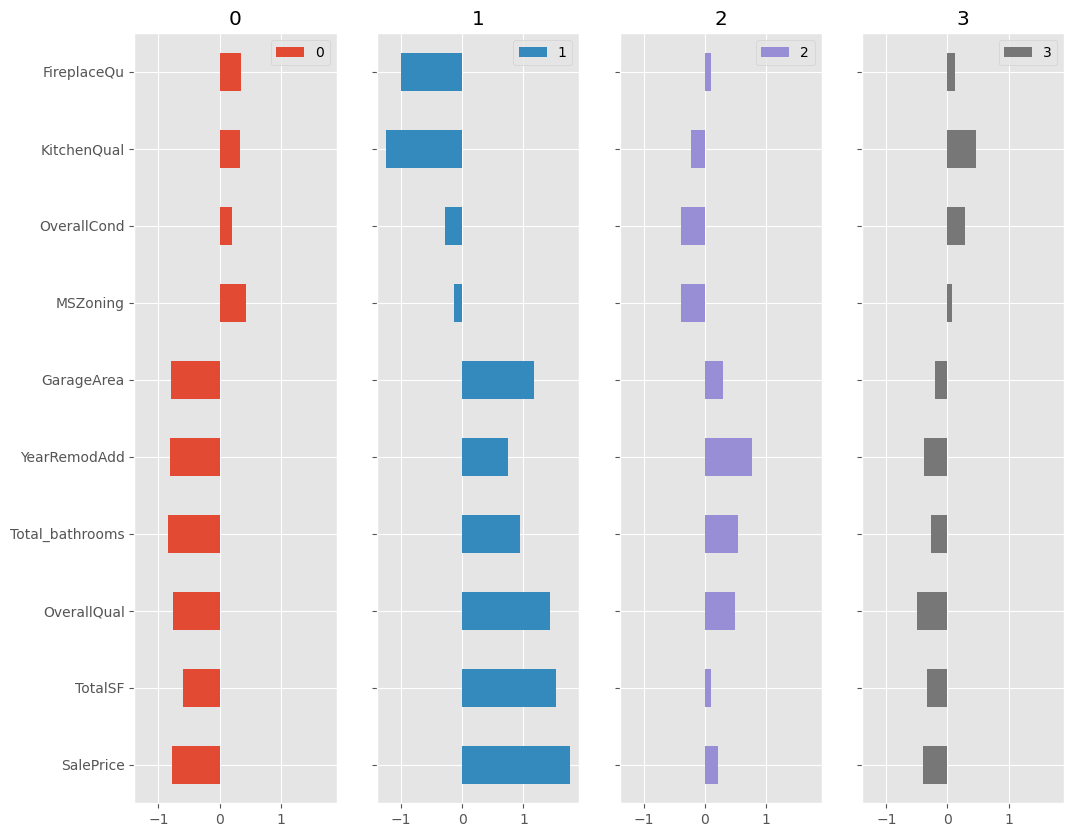

In [56]:
cluster_mean[1:].plot(
    figsize=(12, 10), kind="barh", subplots=True, layout=(1, 4), sharey=True
)

In [57]:
from sklearn.decomposition import PCA

In [58]:
pca = PCA(n_components=2)
house_pca = pca.fit(train_scaled).transform(train_scaled)

In [59]:
house_pca

array([[ 2.32461349, -1.02312033],
       [ 0.42970831, -0.8906041 ],
       [ 2.93109684, -0.93850171],
       ...,
       [ 1.94460898,  2.96602274],
       [-2.98213021, -1.1143295 ],
       [-0.7497288 , -1.26640147]])

In [60]:
house_pca_df = pd.DataFrame(house_pca)
house_pca_df.columns = ["PC1", "PC2"]

In [61]:
train_scaled_df = pd.concat([train_scaled_df, house_pca_df], axis=1)

In [62]:
train_scaled_df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,YrSold,SaleType,SaleCondition,SalePrice,TotalSF,Total_bathrooms,SalePrice_log,km_cluster,PC1,PC2
0,0.073375,-0.045532,-0.212720,-0.207142,0.064238,0.244717,0.750731,0.314667,-0.02618,0.604670,...,0.138777,0.313867,0.208502,0.347273,-0.001277,1.701318,0.560068,2,2.324613,-1.023120
1,-0.872563,-0.045532,0.468158,-0.091886,0.064238,0.244717,0.750731,0.314667,-0.02618,-0.628316,...,-0.614439,0.313867,0.208502,0.007288,-0.052407,0.617108,0.212764,3,0.429708,-0.890604
2,0.073375,-0.045532,-0.076544,0.073480,0.064238,0.244717,-1.378933,0.314667,-0.02618,0.604670,...,0.138777,0.313867,0.208502,0.536154,0.169157,1.701318,0.734046,2,2.931097,-0.938502
3,0.309859,-0.045532,-0.439679,-0.096897,0.064238,0.244717,-1.378933,0.314667,-0.02618,-1.861302,...,-1.367655,0.313867,-3.426284,-0.515281,-0.114493,-0.467101,-0.437382,3,-1.220589,1.774564
4,0.073375,-0.045532,0.649725,0.375148,0.064238,0.244717,-1.378933,0.314667,-0.02618,-0.628316,...,0.138777,0.313867,0.208502,0.869843,0.944631,1.701318,1.014651,1,5.393740,0.650162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.073375,-0.045532,-0.348895,-0.260560,0.064238,0.244717,0.750731,0.314667,-0.02618,0.604670,...,-0.614439,0.313867,0.208502,-0.074560,0.040114,0.617108,0.121434,2,0.994807,-0.130594
1456,-0.872563,-0.045532,0.695117,0.266407,0.064238,0.244717,0.750731,0.314667,-0.02618,0.604670,...,1.645210,0.313867,0.208502,0.366161,1.275760,0.617108,0.578020,3,1.621957,0.613433
1457,0.309859,-0.045532,-0.167328,-0.147810,0.064238,0.244717,0.750731,0.314667,-0.02618,0.604670,...,1.645210,0.313867,0.208502,1.077611,1.126022,-0.467101,1.174708,2,1.944609,2.966023
1458,-0.872563,-0.045532,-0.076544,-0.080160,0.064238,0.244717,0.750731,0.314667,-0.02618,0.604670,...,1.645210,0.313867,0.208502,-0.488523,-0.500404,-0.467101,-0.399656,3,-2.982130,-1.114330


In [63]:
my_color = plt.rcParams["axes.prop_cycle"].by_key()["color"]

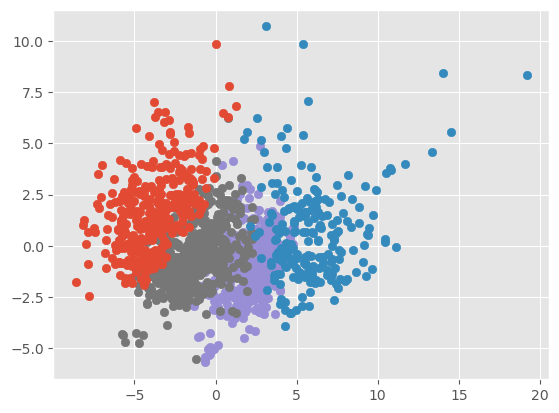

In [64]:
for cl in train_scaled_df["km_cluster"].unique():
    tmp = train_scaled_df[train_scaled_df["km_cluster"] == cl]
    plt.scatter(tmp["PC1"], tmp["PC2"], color=my_color[cl], label=cl)

In [67]:
pca_comp_df = pd.DataFrame(
    pca.components_,
    columns=train_scaled_df.drop(["km_cluster", "PC1", "PC2"], axis=1).columns,
).T
pca_comp_df.columns = ["PC1", "PC2"]

In [68]:
pca_comp_df

,PC1,PC2
MSSubClass,-0.010371,-0.025750
MSZoning,-0.065311,0.067908
LotFrontage,0.103914,0.139451
LotArea,0.067299,0.112807
Street,0.006509,0.007379
...,...,...
SaleCondition,0.063964,-0.050410
SalePrice,0.244914,0.055974
TotalSF,0.225788,0.180915
Total_bathrooms,0.195463,0.029978


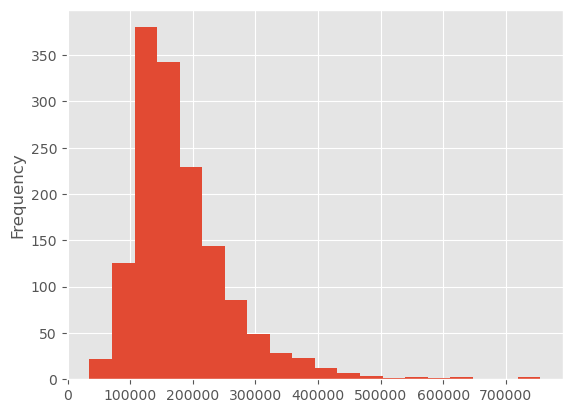

In [69]:
train_df_le["SalePrice"].plot.hist(bins=20)

In [70]:
train_df_le["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [71]:
train_df["SalePrice"].quantile(0.9)

278000.0

In [72]:
train_df_le.loc[train_df["SalePrice"] >= 278000, "high_class"] = 1

c:\ProgramData\Anaconda3\envs\kaggle_book\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\ProgramData\Anaconda3\envs\kaggle_book\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [74]:
train_df_le["high_class"].fillna(0, inplace=True)

c:\ProgramData\Anaconda3\envs\kaggle_book\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [76]:
train_df_le["high_class"].value_counts()

0.0    1313
1.0     147
Name: high_class, dtype: int64

In [91]:
import sys
import pprint

pprint.pprint(sys.path)

['c:\\chungnam_chatbot\\kaggle_book',
 'c:\\ProgramData\\Anaconda3\\envs\\kaggle_book\\python37.zip',
 'c:\\ProgramData\\Anaconda3\\envs\\kaggle_book\\DLLs',
 'c:\\ProgramData\\Anaconda3\\envs\\kaggle_book\\lib',
 'c:\\ProgramData\\Anaconda3\\envs\\kaggle_book',
 '',
 'c:\\ProgramData\\Anaconda3\\envs\\kaggle_book\\lib\\site-packages',
 'c:\\ProgramData\\Anaconda3\\envs\\kaggle_book\\lib\\site-packages\\win32',
 'c:\\ProgramData\\Anaconda3\\envs\\kaggle_book\\lib\\site-packages\\win32\\lib',
 'c:\\ProgramData\\Anaconda3\\envs\\kaggle_book\\lib\\site-packages\\Pythonwin',
 'c:\\ProgramData\\Anaconda3\\envs\\kaggle_book\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\Administrator\\.ipython']


In [92]:
from sklearn import tree
import pydotplus
from six import StringIO

In [93]:
tree_x = train_df_le[
    [
        "TotalSF",
        "OverallQual",
        "Total_bathrooms",
        "YearRemodAdd",
        "GarageArea",
        "MSZoning",
        "OverallCond",
        "KitchenQual",
        "FireplaceQu",
    ]
]
tree_y = train_df_le["high_class"]

In [94]:
clf = tree.DecisionTreeClassifier(max_depth=3, random_state=1234)
clf = clf.fit(tree_x, tree_y)

In [95]:
dot_data = StringIO()
tree.export_graphviz(clf, out_file=dot_data, feature_names=tree_x.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

In [96]:
import os

os.environ["PATH"] += os.pathsep + "C:/Program Files/Graphviz/bin"

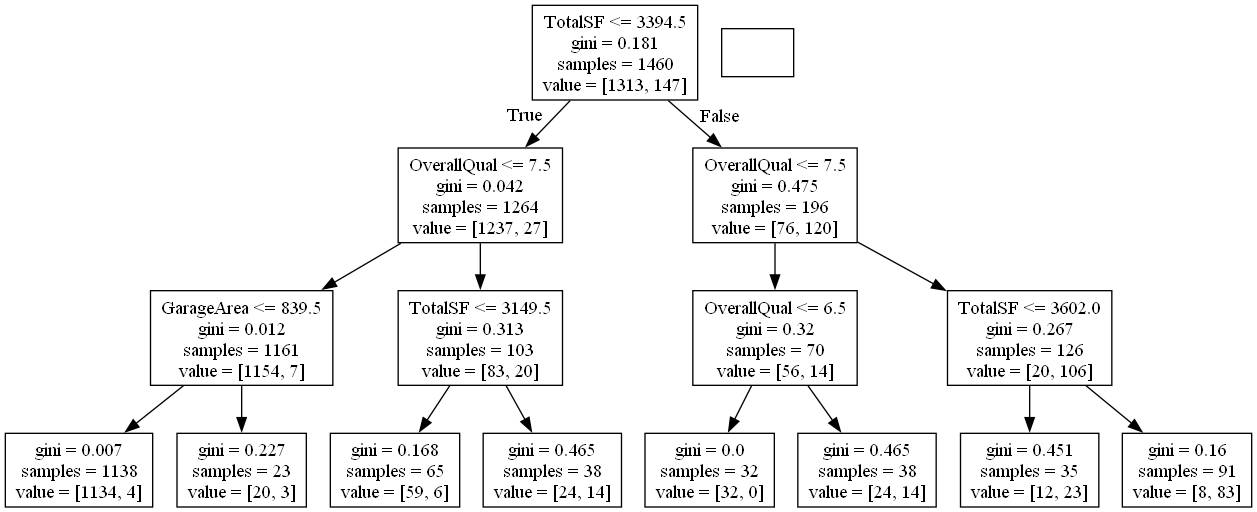

In [99]:
from IPython.display import Image

# from PIL import Image
Image(graph.create_png())
# test code Image
# graph.write_png("./data/tree.png")
# imgae = graph.create_png()